# Random Forest - Exploración de ventanas 
## Grado en Ingeniería Informática. Universidad de Burgos
**Autor:** Alicia Olivares Gil

In [1]:
%matplotlib inline 
#para dibujar en el propio notebook
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #matplotlib.pyplot como plot
import pickle as pk
import loadData as ld
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mtr
import seaborn as sns
from transformers import StatisticsTransformer, MoveTargetsTransformer, ConcatenateTransformer, PipelineTransformer

In [2]:
with open('diacrisis1.pdd','rb') as f: 
    diacrisis1 = pk.load(f) 
print(len(diacrisis1))
diacrisis1.head()

121979


,DateTime,P1,P2,P3,P4,P5,P6,target
3396348,2018-11-09 21:02:53,0.0,18.852459,22.131148,22.950820,13.934426,6.557377,False
3396346,2018-11-09 21:02:53,0.0,19.672131,22.950820,23.770492,13.934426,7.377049,False
3396345,2018-11-09 21:02:53,0.0,18.852459,22.131148,22.950820,13.934426,6.557377,False
3396347,2018-11-09 21:02:53,0.0,19.672131,22.950820,22.950820,13.934426,6.557377,False
3396349,2018-11-09 21:02:53,0.0,18.852459,22.131148,22.950820,13.934426,6.557377,False


In [3]:
with open('diacrisis2.pdd','rb') as f: 
    diacrisis2 = pk.load(f) 
print(len(diacrisis2))
diacrisis2.head()

123525


,DateTime,P1,P2,P3,P4,P5,P6,target
5994110,2019-01-28 21:15:02,0.0,18.032787,15.573770,18.032787,6.557377,4.918033,False
5994111,2019-01-28 21:15:02,0.0,18.032787,16.393443,18.032787,7.377049,4.918033,False
5994112,2019-01-28 21:15:02,0.0,18.852459,16.393443,18.852459,7.377049,4.918033,False
5994113,2019-01-28 21:15:03,0.0,19.672131,16.393443,18.852459,7.377049,4.918033,False
5994114,2019-01-28 21:15:03,0.0,18.852459,16.393443,18.852459,7.377049,4.918033,False


In [4]:
def explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, mode='only'): 
    heatmap = []
    
    for window_std in rango_std: 
        
        row=[]
        transformer_std = StatisticsTransformer(mode='std', window=window_std)
        transformer_move_targets_std = MoveTargetsTransformer(window=window_std, mode=mode)
        
        for window_mean in rango_mean: 

            transformer_mean = StatisticsTransformer(mode='mean', window=window_mean)
            transformer_move_targets_mean = MoveTargetsTransformer(window=window_mean, mode=mode)
            
            transformer_concat = ConcatenateTransformer(transformer_std, transformer_mean)

            stats1 = transformer_concat.fit_transform(diacrisis1.drop(["DateTime","target"],axis=1)) 
            stats1 = pd.concat([stats1,diacrisis1["target"]],axis=1)
            stats1 = stats1.dropna()

            stats2 = transformer_concat.fit_transform(diacrisis2.drop(["DateTime","target"],axis=1))
            stats2 = pd.concat([stats2,diacrisis2["target"]],axis=1)
            stats2 = stats2.dropna()
            
            if(window_std < window_mean): 
                stats1 = transformer_move_targets_std.fit_transform(stats1)
                stats2 = transformer_move_targets_std.fit_transform(stats2)
            else: 
                stats1 = transformer_move_targets_mean.fit_transform(stats1)
                stats2 = transformer_move_targets_mean.fit_transform(stats2)
                
            #entrenar con crisis1 y predecir crisis2
            rfc1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
            rfc1.fit(stats1.drop(["target"],axis=1), stats1["target"])

            y_pred = rfc1.predict_proba(stats2.drop(["target"],axis=1))
            y_score = [i[0] for i in y_pred]
            roc1 = mtr.roc_auc_score(stats2["target"],y_score)

            #entrenar con crisis2 y predecir crisis1
            rfc2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
            rfc2.fit(stats2.drop(["target"],axis=1), stats2["target"])

            y_pred = rfc2.predict_proba(stats1.drop(["target"],axis=1))
            y_score = [i[0] for i in y_pred]
            roc2 = mtr.roc_auc_score(stats1["target"],y_score)

            row.append((roc1+roc2)/2)

        heatmap.append(row)
    return heatmap

In [5]:
rango_std = list(range(5,200,25))
rango_mean = list(range(5,200,25))
heatmap_only = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'only')
heatmap_half = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'half')
heatmap_end = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'end')

Text(0.5, 1.0, 'labeled if one is crisis')

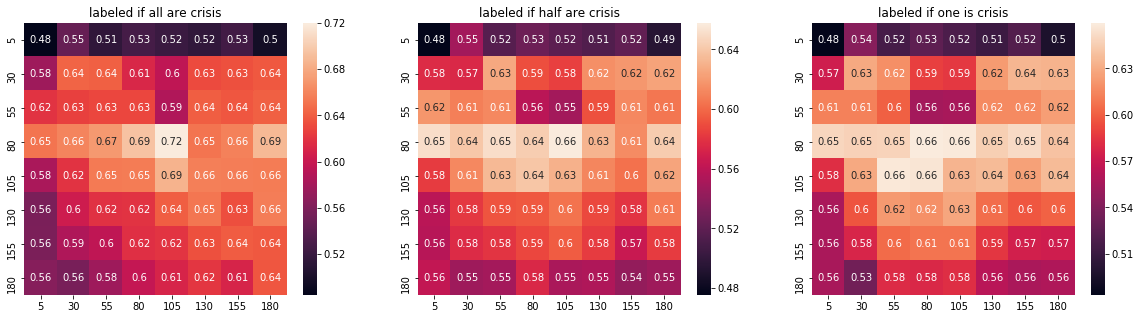

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.heatmap(heatmap_only,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if all are crisis")
plt.subplot(132)
sns.heatmap(heatmap_half,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if half are crisis")
plt.subplot(133)
sns.heatmap(heatmap_end,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if one is crisis")

In [5]:
rango_std = list(range(70,115,5))
rango_mean = list(range(30,200,25))
heatmap_only = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'only')
heatmap_half = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'half')
heatmap_end = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'end')

Text(0.5, 1.0, 'labeled if one is crisis')

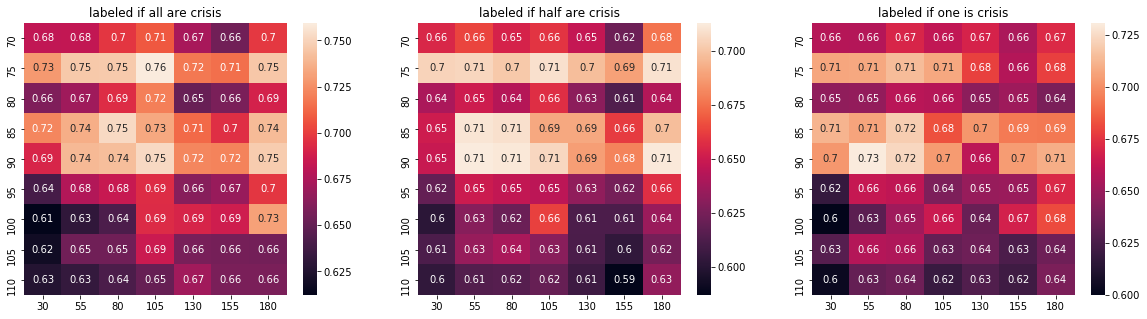

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.heatmap(heatmap_only,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if all are crisis")
plt.subplot(132)
sns.heatmap(heatmap_half,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if half are crisis")
plt.subplot(133)
sns.heatmap(heatmap_end,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if one is crisis")

In [5]:
rango_std = list(range(80,95,2))
rango_mean = list(range(40,200,25))
heatmap_only = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'only')
heatmap_half = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'half')
heatmap_end = explorar_ventanas_random_forest(rango_std, rango_mean, diacrisis1, diacrisis2, 'end')

Text(0.5, 1.0, 'labeled if one is crisis')

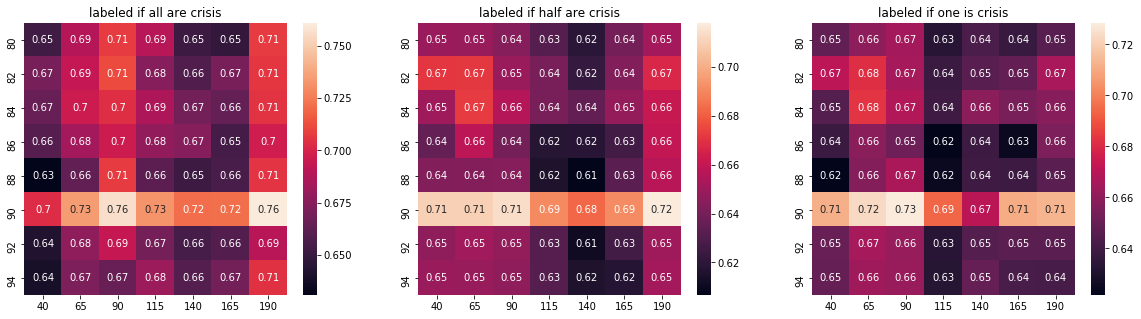

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.heatmap(heatmap_only,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if all are crisis")
plt.subplot(132)
sns.heatmap(heatmap_half,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if half are crisis")
plt.subplot(133)
sns.heatmap(heatmap_end,annot=True, xticklabels=rango_mean, yticklabels=rango_std)
plt.title("labeled if one is crisis")